In [28]:
import test_saliency.utils as ts
reload(ts)

<module 'test_saliency.utils' from 'test_saliency/utils.pyc'>

In [24]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.cluster import MeanShift, estimate_bandwidth

from test_saliency.utils import decode, ssConvertMap, ssConvertString, aaString_jurtz, aaMap_jurtz, pssmString_jurtz, pssmMap_jurtz, convertPredictQ8Result2HumanReadable

### Loading data

In [1]:
from secondary_proteins_prediction import data

TRAIN_PATH = 'secondary_proteins_prediction/data/cullpdb+profile_6133_filtered.npy.gz'
TEST_PATH = 'secondary_proteins_prediction/data/cb513+profile_split1.npy.gz'

X_train, X_valid, labels_train, labels_valid, mask_train, mask_valid, _ = data.get_train(TRAIN_PATH)
X_test, mask_test, labels_test, _ = data.get_test(TEST_PATH)
print X_train[:-30].shape, X_valid.shape, X_test[:-126].shape
split_value = len(X_train[:-30]) + len(X_valid)
print split_value

X = np.concatenate((X_train[:-30],X_valid, X_test[:-126]))
labels = np.concatenate((labels_train[:-30],labels_valid, labels_test[:-126]))
mask = np.concatenate((mask_train[:-30],mask_valid, mask_test[:-126]))
print X.shape

Train path is downloaded ...
Loading train data ...
Loading splits ...
Loading test data ...
(5248, 700, 42) (256, 700, 42) (514, 700, 42)
5504


NameError: name 'np' is not defined

In [5]:
predictions_path = "secondary_proteins_prediction/predictions/predictions_train_valid_pureConv-20180804-010835-47.npy"
predictions = np.load(predictions_path)
print "train_val", predictions.shape

predictions_path = "secondary_proteins_prediction/predictions/predictionstest_pureConv-20180804-010835-47.npy"
predictions2 = np.load(predictions_path)
print "test", predictions2[:-126].shape

predictions = np.concatenate((predictions, predictions2[:-126]))
print "total", predictions.shape

train_val (5504, 700, 8)
test (514, 700, 8)
total (6018, 700, 8)


In [65]:
6018 // 64

94

In [31]:
5278 // 64

82

In [32]:
5534 // 64

86

## Individual saliencies

**Collect saliencies**

In [6]:
target_class = "H"
num_seqs = 4
saliencies = []
for seq in range(num_seqs):
    with open("test_saliency/saliencies_jurtz/saliencies"+str(seq)+target_class+".pkl", "rb") as f:
        saliencies.append(np.array(pickle.load(f)))
        #saliencies[:,:,seq,:,:] = temp[:,:,0,:,:]
print("Saliencies length", len(saliencies))
print("Saliency sequence shape", saliencies[0].shape)

('Saliencies length', 4)
('Saliency sequence shape', (315, 315, 42))


**Inspect sequential saliency**

''

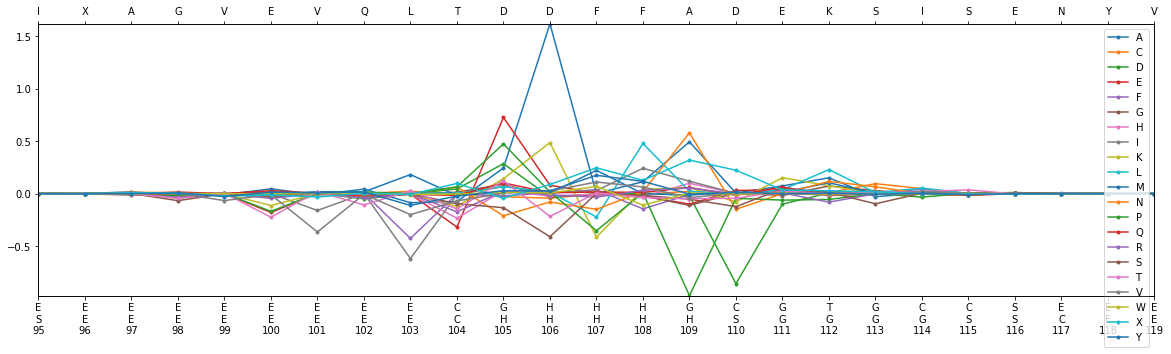

In [131]:
seq = 0
final_pos = 110
window = 9
ini = 95

end = final_pos + window + 1
end_seq = int(sum(mask[seq]))
if end > end_seq:
    end = end_seq
if final_pos > end_seq:
    final_pos = end_seq

preds = convertPredictQ8Result2HumanReadable( predictions[seq] )
temp = saliencies[seq]

def plot_individuals(temp, ini, end, seq):
    fig, ax = plt.subplots(figsize=(15,3))
    for pos in range(ini,final_pos):
        #if True:
        if preds[pos] == 'H':
        #if ssConvertMap[labels[seq,pos]] == 'H':
            sal = np.einsum('ij,ij->i', temp[pos,ini:end,21:], X[seq,ini:end,21:])
            ax.plot(sal, marker='.', label=str(pos))
            #ax.plot(np.sum(np.sum(abs(saliencies[:,pos,seq,:end,:]), axis=2), axis=0), marker='.') # Aminoacid importance
    ax.legend()
    return ax
    
def plot_aggregated_saliency(temp, ini, end, seq):
    fig, ax = plt.subplots(figsize=(15,0.64))
    tot_sal = np.zeros(end-ini)
    for pos in range(ini,final_pos):
        if True:
        #if preds[pos] == 'H':
        #if ssConvertMap[labels[seq,pos]] == 'H':
            sal = np.einsum('ij,ij->i', temp[pos,ini:end,21:], X[seq,ini:end,21:])
            tot_sal += sal
    #ax.plot(tot_sal, marker='.')
    vmax = np.max(abs(tot_sal))
    cax = ax.imshow(tot_sal[None,:], cmap='seismic', vmin = -vmax, vmax = vmax)
    #fig.colorbar(cax)
    return ax

def plot_aggregated_pssm(temp, ini, end, seq):
    fig, ax = plt.subplots(figsize=(20,5))
    tot_sal = np.zeros((end-ini, 21))
    for pos in range(ini,final_pos):
        if True:
        #if preds[pos] == 'H':
        #if ssConvertMap[labels[seq,pos]] == 'H':
            sal = np.multiply(temp[pos,ini:end,21:], X[seq,ini:end,21:])
            tot_sal += sal
    ax.plot(tot_sal, marker='.')
    ax.legend(pssmString_jurtz)
    return ax

#ax = plot_individuals(temp, ini, end, seq)
#ax = plot_aggregated_saliency(temp, ini, end, seq)
ax = plot_aggregated_pssm(temp, ini, end, seq)

ax.xaxis.set(ticks=range(end-ini), ticklabels=[preds[ini+i]+"\n"+ssConvertMap[el]+"\n"+str(ini+i) for i, el in enumerate(labels[seq,ini:end])])
ax.margins(0)
ax2 = ax.twiny()
ax2.xaxis.set(ticks=range(end-ini), ticklabels=decode(X[seq,ini:end], aaMap_jurtz))
""

**Inspect sliding saliencies**

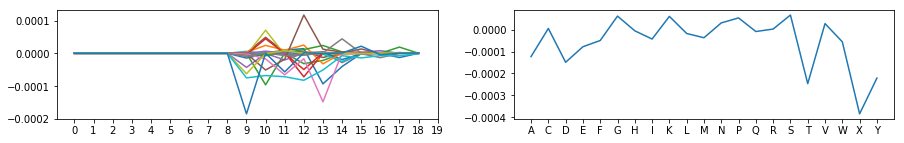

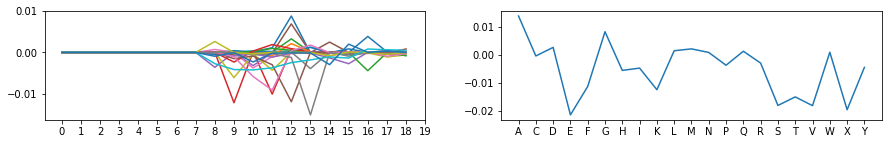

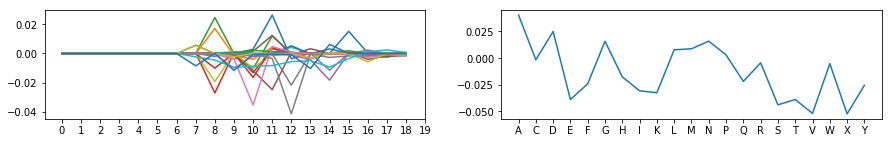

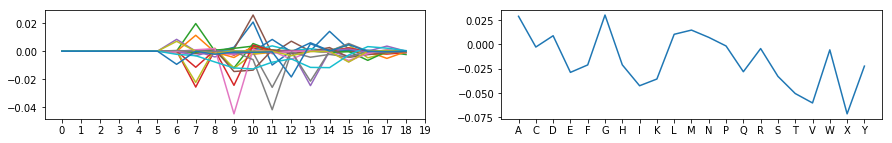

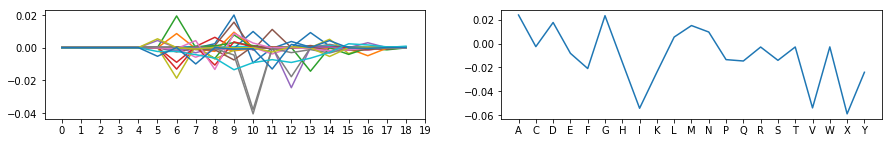

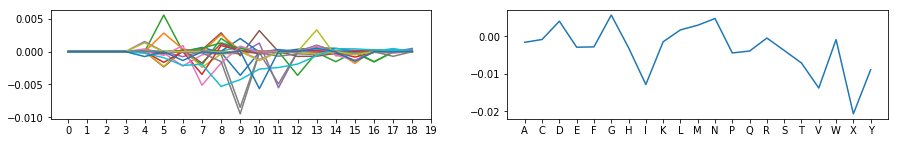

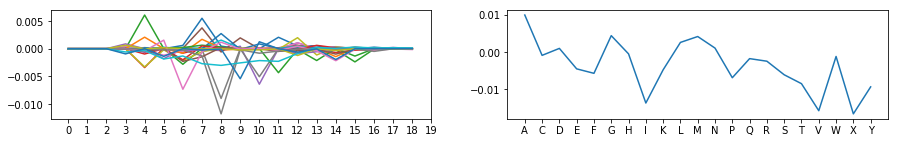

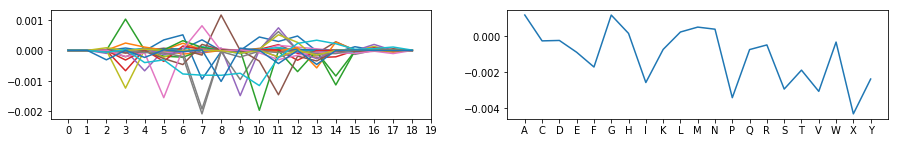

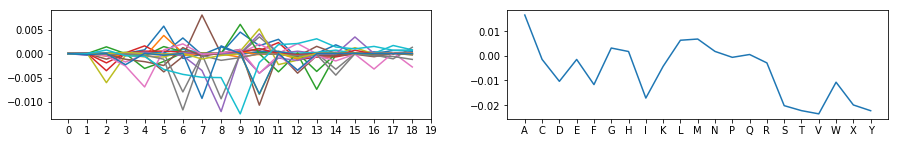

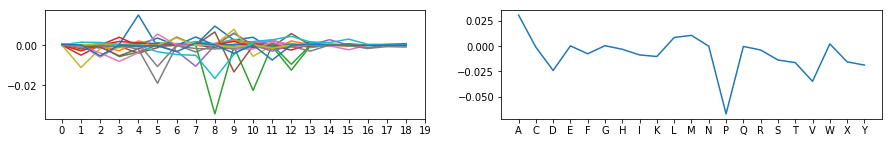

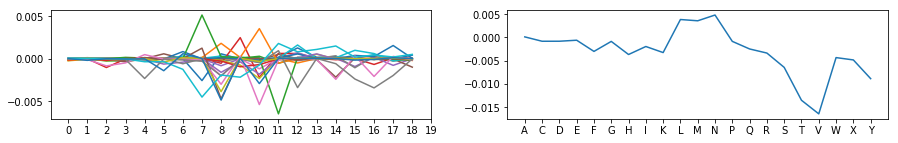

In [143]:
window = 9
total = np.zeros((2*window + 1, 42)) # window-size, n aminoacids
for seq, saliency in enumerate(saliencies):
    end_seq = int(sum(mask[seq]))
    for pos in range(end_seq):
        prev_tot = np.copy(total)
        # Pre-window
        if pos > window:
            init = pos - window
            total[:window] += np.multiply(saliency[pos,init:pos,:], X[seq,init:pos])
        elif pos != 0:
            init = window - pos
            total[init:window] += np.multiply(saliency[pos,0:pos,:], X[seq,0:pos])
        
        # Window
        total[window] += np.multiply(saliency[pos,pos,:], X[seq,pos])

        # Post-window
        if pos + window + 1 <= end_seq:
            end = pos + window + 1
            total[window+1:] += np.multiply(saliency[pos,pos+1:end,:], X[seq,pos+1:end])
        elif pos != end_seq:
            end = end_seq
            total[window+1:-(pos+window+1-end)] += np.multiply(saliency[pos,pos+1:end,:], X[seq,pos+1:end])
        
        # Print position saliency
        tot_plot = total - prev_tot
        if True:
            fig,(ax1, ax2) = plt.subplots(1,2, figsize=(15,2))
            ax1.plot(tot_plot[:,21:])
            ax1.xaxis.set(ticks=range(20), ticklabels=pssmString_jurtz)
            
            ax2.plot(np.sum(tot_plot[:,21:], axis=0))
            ax2.xaxis.set(ticks=range(21), ticklabels=pssmString_jurtz)
            if pos == 10:
                break
    break
        
def plot1(total, aaString_jurtz, pssmString_jurtz):
    fig, ax = plt.subplots(figsize=(20,5))
    ## WRONG, aminoacids and pssm have different codings, so indexes must be re-arranged
    for el in range(21):
        ax.plot( total[:,el] + total[:,el+21], label=aaString_jurtz[el], marker='.')
    ax.legend()
        

def plot2(total, aaString_jurtz, pssmString_jurtz):
    fig, axes = plt.subplots(1,2, figsize=(20,5))
    ax = axes[0]
    ax1 = axes[1]
    for el in range(21):
        ax.plot(total[:,el], label=aaString_jurtz[el], marker='.')
        ax1.plot(total[:,el+21], label=pssmString_jurtz[el], marker='.')
    ax.legend()
    ax.set(ylim= [-10, 10], title="Aggregated saliencies (one-hot)")
    ax1.legend()
    ax1.set(ylim= [-10, 10], title="Aggregated saliencies (pssm)")
    plt.tight_layout()
    
#plot1(total, aaString_jurtz, pssmString_jurtz)
#plot2(total, aaString_jurtz, pssmString_jurtz)

## Aggregated saliencies

### Sheer addition 

In [30]:
def plot_SeqLogo(total, target_class):
    fig, axes = plt.subplots(1,2, figsize=(20,5))
    ax = axes[0]
    ax1 = axes[1]
    for el in range(21):
        ax.plot(total[:,el], label=aaString_jurtz[el], marker='.')
        ax1.plot(total[:,el+21], label=pssmString_jurtz[el], marker='.')
    ax.legend()
    vmax = np.max(abs(total[:,21:]))
    ax.set(ylim= [-vmax, vmax], title="Aggregated saliencies (one-hot): "+target_class)
    ax1.legend(loc='right')
    ax1.set(ylim= [-vmax, vmax], title="Aggregated saliencies (pssm): "+target_class)
    plt.tight_layout()

**Aggregate from individuals**

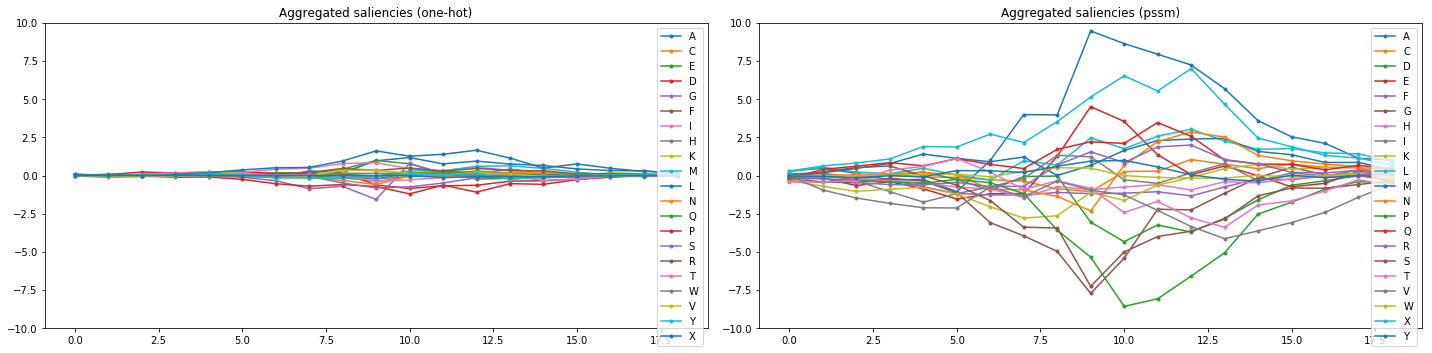

In [125]:
window = 9
total = np.zeros((2*window + 1, 42)) # window-size, n aminoacids
for seq, saliency in enumerate(saliencies):
    end_seq = int(sum(mask[seq]))
    for pos in range(end_seq):
        # Pre-window
        if pos > window:
            init = pos - window
            total[:window] += np.multiply(saliency[pos,init:pos,:], X[seq,init:pos])
        elif pos != 0:
            init = window - pos
            total[init:window] += np.multiply(saliency[pos,0:pos,:], X[seq,0:pos])

        # Window
        total[window] += np.multiply(saliency[pos,pos,:], X[seq,pos])

        # Post-window
        if pos + window + 1 <= end_seq:
            end = pos + window + 1
            total[window+1:] += np.multiply(saliency[pos,pos+1:end,:], X[seq,pos+1:end])
        elif pos != end_seq:
            end = end_seq
            total[window+1:-(pos+window+1-end)] += np.multiply(saliency[pos,pos+1:end,:], X[seq,pos+1:end])

plotSeqLogo(total)

**Or load from file**

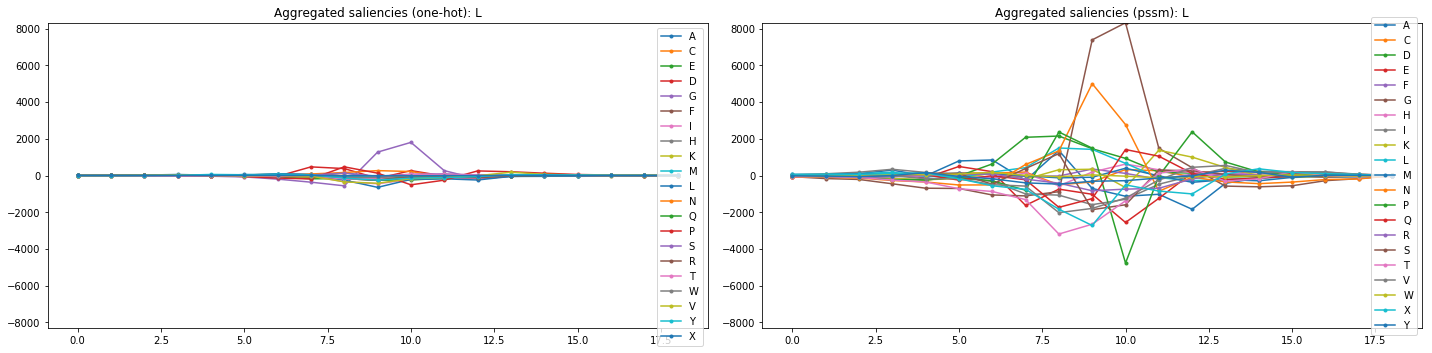

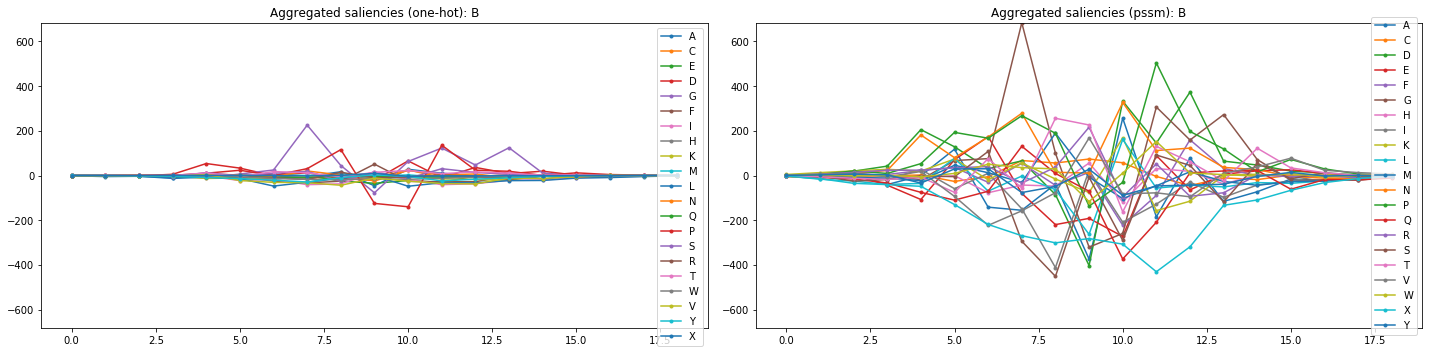

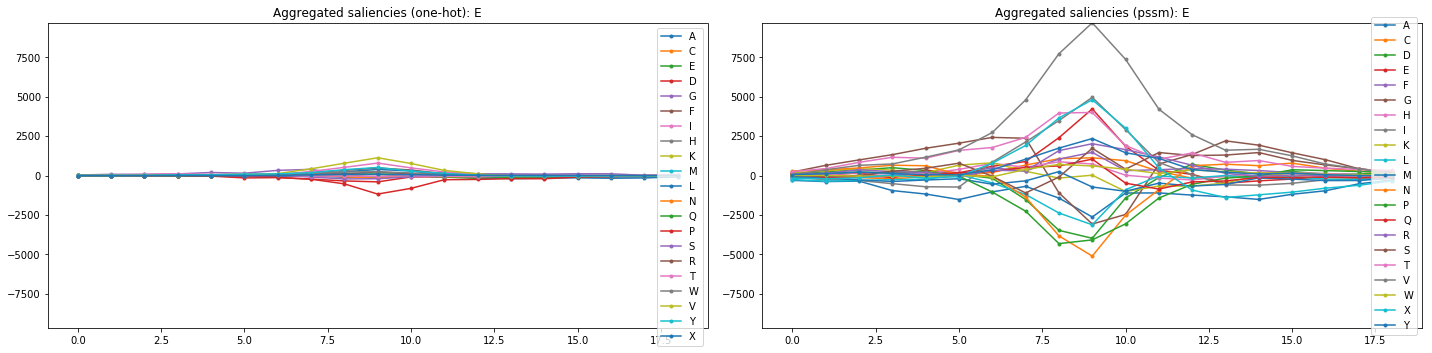

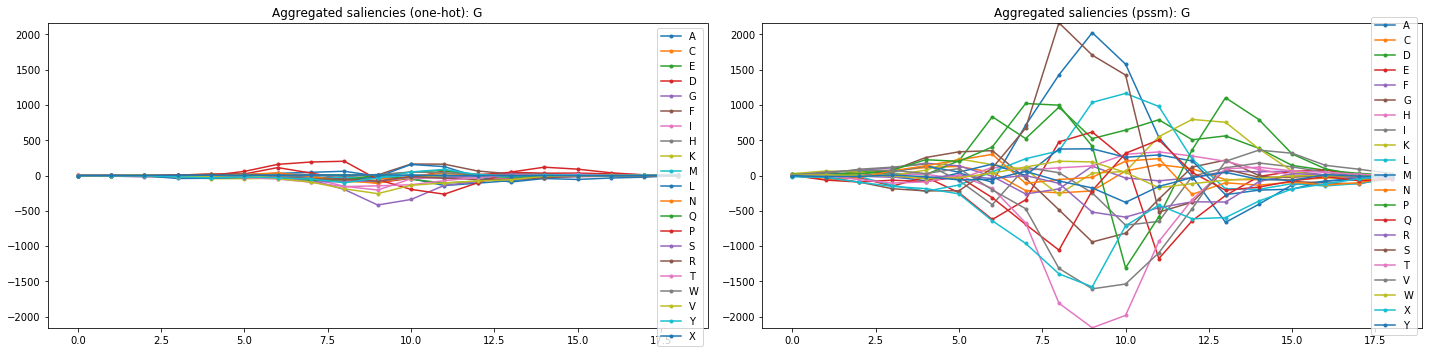

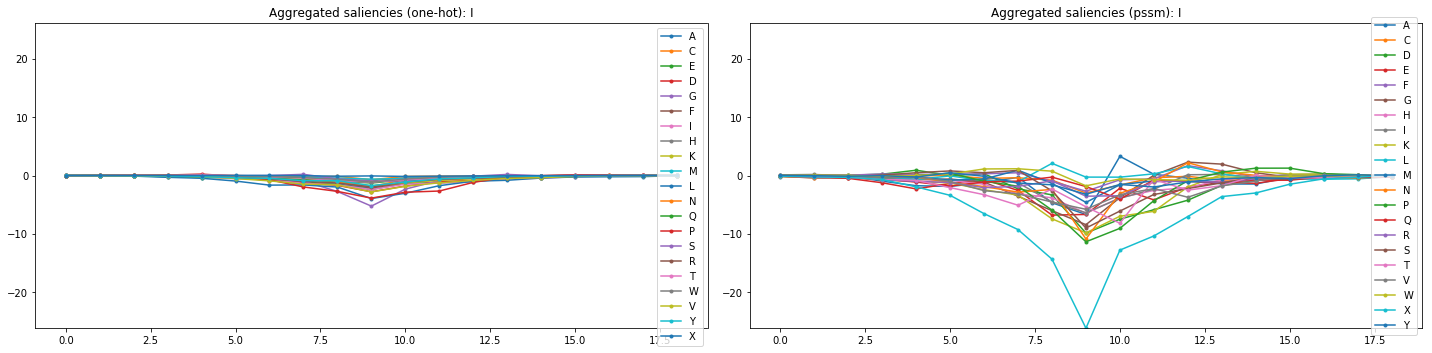

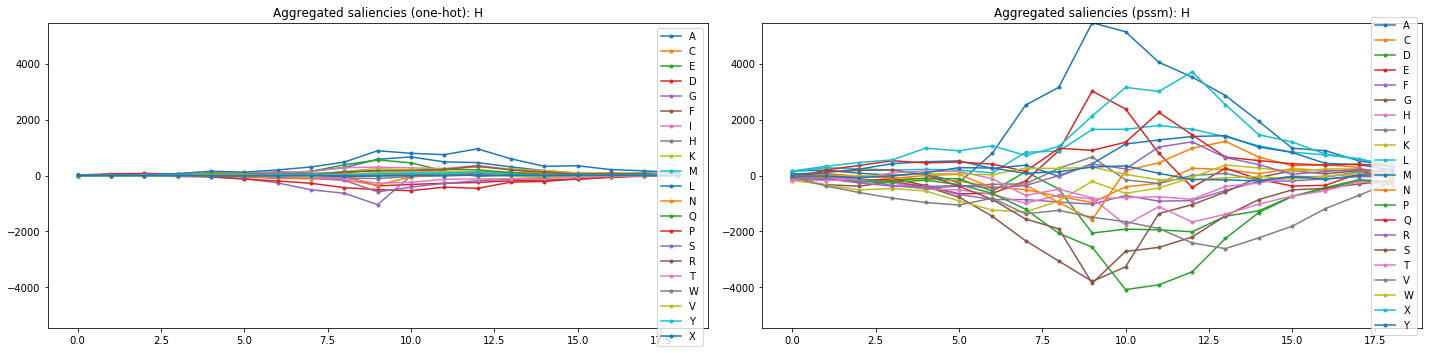

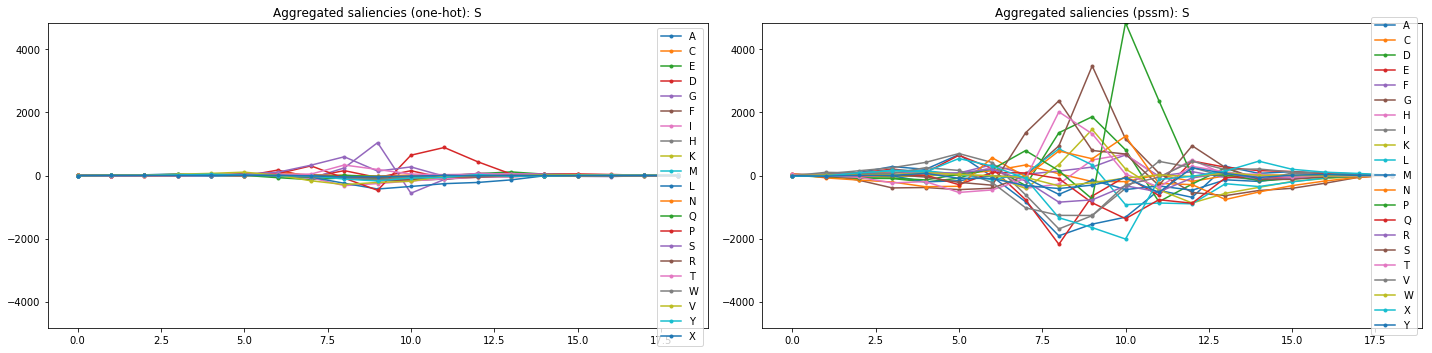

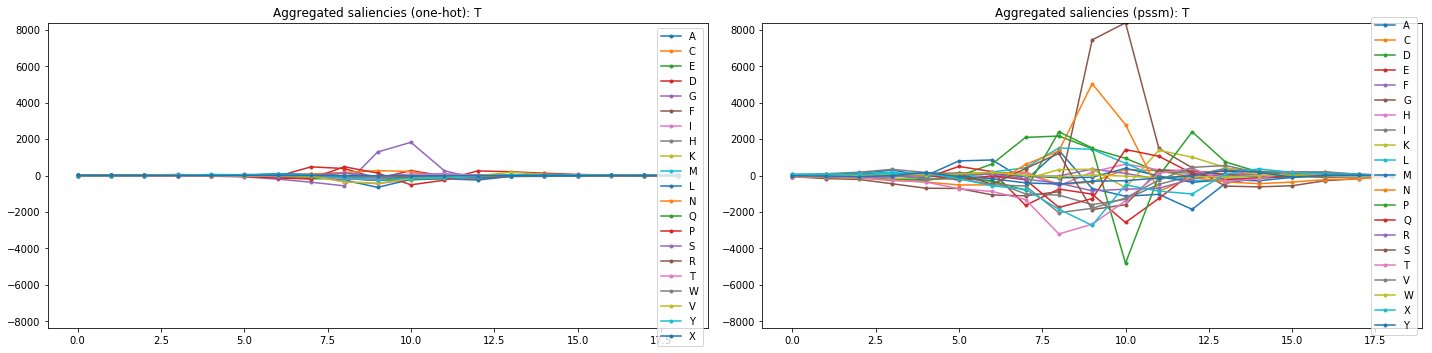

In [33]:
for target_class in ssConvertString:
    num_seqs = 6018

    with open("test_saliency/SeqLogos/SeqLogo"+str(num_seqs)+target_class+".pkl", "rb") as f:
        total = pickle.load(f)
    #print("Total shape", total.shape)
    
    plot_SeqLogo(total, target_class)

**Execute addition**

**To SeqLogo Motif**

In [108]:
for row in range(len(total)):
    print " ".join("{:.8f}".format(el) for el in total[row,21:])

0.29468806 0.05435745 -0.13408292 -0.21573860 0.10824658 -0.18844148 -0.06816817 0.12199252 -0.33088783 0.25764202 0.04400279 -0.34589766 -0.13999956 -0.18326531 -0.13869860 -0.11299553 -0.41485305 -0.03232166 -0.00092536 0.28841944 -0.02793120
0.47708828 0.11701081 -0.04872066 -0.17479242 -0.00242900 -0.42851908 -0.05435811 0.15581632 -0.71000025 0.54254288 0.17840517 -0.08932093 -0.21111538 0.40037828 -0.22045048 0.25001444 -0.44513811 -0.95090556 -0.01817636 0.62790542 -0.06045732
0.13983225 -0.04665493 -0.20489623 -0.65762778 -0.20957667 -0.47555020 -0.23164906 -0.36198218 -1.03664063 0.22300125 0.46448108 0.06666851 -0.31970208 0.61047386 -0.45472681 0.52055792 -0.33462587 -1.47314823 -0.01814645 0.81475125 -0.14147653
-0.29114661 0.01724052 0.02114607 -0.40677295 -0.27752121 -0.17933684 -0.34603729 -1.05817983 -0.89517074 0.12160514 0.78555828 0.09760374 -0.42872128 0.84404803 -0.59825777 0.62102815 0.35542352 -1.82488087 0.01784679 1.08319790 -0.01606637
-0.25854019 -0.10225564 

### Clustering

In [12]:
saliencies[0].shape

(315, 315, 42)

In [22]:
window = 9
label = 'H'
points = []
for seq, saliency in enumerate(saliencies):
    preds = convertPredictQ8Result2HumanReadable( predictions[seq] )
    end_seq = int(sum(mask[seq]))
    for pos in range(end_seq):
        if preds[pos] == label:
            total = np.zeros((2*window + 1, 42)) # window-size, n aminoacids
            # Pre-window
            if pos > window:
                init = pos - window
                total[:window] += np.multiply(saliency[pos,init:pos,:], X[seq,init:pos])
            elif pos != 0:
                init = window - pos
                total[init:window] += np.multiply(saliency[pos,0:pos,:], X[seq,0:pos])

            # Window
            total[window] += np.multiply(saliency[pos,pos,:], X[seq,pos])

            # Post-window
            if pos + window + 1 <= end_seq:
                end = pos + window + 1
                total[window+1:] += np.multiply(saliency[pos,pos+1:end,:], X[seq,pos+1:end])
            elif pos != end_seq:
                end = end_seq
                total[window+1:-(pos+window+1-end)] += np.multiply(saliency[pos,pos+1:end,:], X[seq,pos+1:end])

            points.append(np.sum(total[:,21:], axis=0))

points = np.array(points)
points = points / np.max(abs(points), axis=1)[:, None]
points.shape

(355, 21)

In [1]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

n_clusters = 2

model = AgglomerativeClustering(n_clusters=n_clusters, linkage="average", affinity="cosine")
model.fit(points)

fig,axes = plt.subplots(n_clusters,2, figsize=(20, 3 * n_clusters))
for l, c in zip(np.arange(n_clusters), 'rgbk'):
    ax = axes[l]
    
    ax[0].axhline(color='k', linewidth=1)
    ax[0].plot(points[model.labels_ == l].T , c=c, alpha=.1)
    ax[0].xaxis.set(ticks=range(21), ticklabels=pssmString_jurtz)
    ax[0].margins(0)
    
    ax[1].axhline(color='k', linewidth=0.5)
    ax[1].plot(np.sum(points[model.labels_ == l].T, axis = 1) , c=c)
    ax[1].xaxis.set(ticks=range(21), ticklabels=pssmString_jurtz)
    ax[1].margins(0)
    ax[1].suptitle("Size = %d)" % len(points[model.labels_ == l]))

NameError: name 'points' is not defined

## Gradient computation drafts

In [25]:
import importlib
import theano
import theano.tensor as T
import lasagne as nn

metadata_path = "secondary_proteins_prediction/metadata/dump_pureConv-20180804-010835-47.pkl"
metadata = np.load(metadata_path)
config_name = metadata['config_name']
config = importlib.import_module("secondary_proteins_prediction.configurations.%s" % config_name)
print("Using configurations: '%s'" % config_name)
print("Build model")
l_in, l_out = config.build_model()
print("Build eval function")
sym_x = T.tensor3()
inference = nn.layers.get_output(
        l_out, sym_x, deterministic=True)
print("Load parameters")
nn.layers.set_all_param_values(l_out, metadata['param_values'])
print("Compile functions")
#predict = theano.function([sym_x], inference)
#gradients = theano.gradient.grad(inference[0,0,7], wrt=sym_x)
gradients = theano.gradient.jacobian(inference[:2,:5,7].flatten(), wrt=sym_x)
get_gradients = theano.function(inputs=[sym_x], outputs=gradients)

Using configurations: 'pureConv'
Build model
Build eval function
Load parameters
Compile functions


In [26]:
inputs = X[:64]
grads = get_gradients(inputs)
grads = np.array(grads)
grads.shape

(10, 64, 700, 42)

In [35]:
grads[0,0,:25,0]

array([ 6.4387197e-05,  4.9815375e-05,  6.3439307e-05, -7.9392616e-05,
       -1.3909835e-05, -1.9522935e-05, -1.5157283e-05, -1.1170907e-05,
       -2.3602274e-07,  1.1610673e-06,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00], dtype=float32)

In [44]:
import glob
import os
#os.chdir('test_saliency/saliencies_jurtz')
files = glob.glob('perro*')
sorted(files)
print files
import re
numbers = []
for el in files:
    #print el
    print re.search(r'(\d+)(\D)', el).groups()
    #numbers.append(int(num.group(0)))
#sorted(numbers)
os.chdir('../..')

['perro10S.pkl', 'perro3P.pkl', 'perro2O.pkl', 'perro1H.pkl', 'perro20R.pkl']
('10', 'S')
('3', 'P')
('2', 'O')
('1', 'H')
('20', 'R')


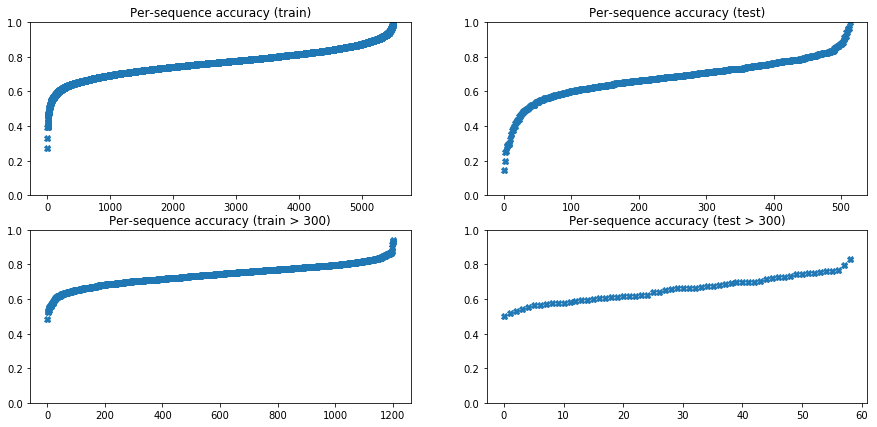

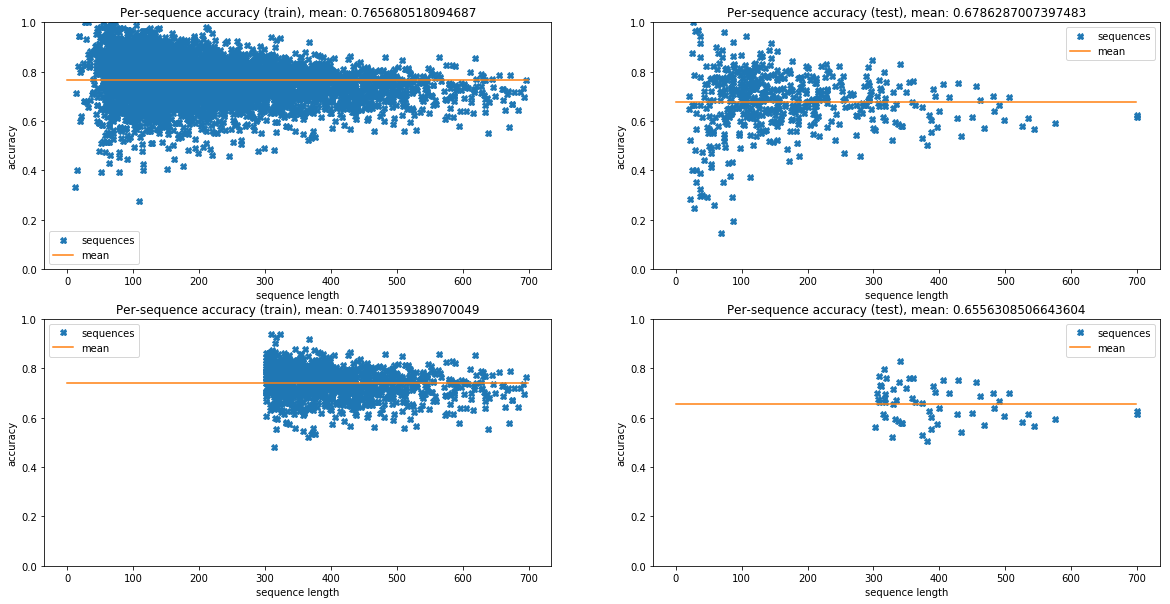